## Application: Wave Damage To Cargo Ships
---

#### Variables:

+ type - type: "A" to "E".
+ year - year of construction: 1960–64, 65–69, 70–74, 75–79 (coded as "60", "65", "70", "75").
+ period - period of operation : 1960–74, 75–79.
+ service - aggregate months of service.
+ incidents - number of damage incidents.

#### Source:

ships - Ships Damage Data

https://vincentarelbundock.github.io/Rdatasets/datasets.html

McCullagh, P. and J. A. Nelder (1983) *Generalized Linear Models*, Second Edition, Chapman & Hall, Table 6.2, Page 205.


In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import scipy.stats as st
from IPython.display import display

We consider the Poisson regression model:

\begin{align*}
 & \log(\text{expected number of damage incidents}) \\
 & = \beta_0 + \beta_1\log(\text{service}) + \beta_2(\text{ship type is B}) + \beta_3(\text{ship type is C}) + \beta_4(\text{ship type is D})+ \beta_5(\text{ship type is E}) \\
 & \quad + \beta_6(\text{year of construction: 1965-69}) + \beta_7(\text{year of construction: 1970-74})
    + \beta_8(\text{year of construction: 1975-79}) \\
 & \quad + \beta_9(\text{year of operation: 1975-79}).
\end{align*}


In [2]:
data = pd.read_csv('ships.csv', index_col=0)

We exclude the observations with `service` = 0.

In [3]:
data = data[data['service'] > 0]
log_service = np.log(data['service'].to_numpy()).reshape((data.shape[0], 1))

Here we create dummy variables for ship types. The dummy variable for "A" is excluded.

In [4]:
str_type = data['type'].unique()
dummy_type = np.zeros((data.shape[0], str_type.size - 1))
for idx, ship_type in enumerate(str_type[1:]):
    dummy_type[:, idx] = (data['type'] == ship_type).to_numpy()

Then we create dummy variables for years of construction. The dummy variable for 1960-64 is excluded.

In [5]:
str_year = data['year'].unique()
dummy_year =  np.zeros((data.shape[0], str_year.size - 1))
for idx, construction_year in enumerate(str_year[1:]):
    dummy_year[:, idx] = (data['year'] == construction_year).to_numpy()

We create the dummy variable for period of operation.

In [6]:
str_period = data['period'].unique()
dummy_period =  np.zeros((data.shape[0], str_period.size - 1))
for idx, operation_period in enumerate(str_period[1:]):
    dummy_period[:, idx] = (data['period'] == operation_period).to_numpy()

Finally we create the matrix of the independent variables `X` and the vector of the dependent variable `y`.

In [7]:
X = np.hstack((np.ones((data.shape[0],1)), log_service, dummy_type, dummy_year, dummy_period))
y = data['incidents'].to_numpy()
var_names = ['constant', 'log_service', 'B', 'C', 'D', 'E', '65-69', '70-74', '75-79', 'operation']

In [8]:
n, k = X.shape
b0 = np.zeros(k)
A0 = 0.01 * np.eye(k)
poisson_regression_model = pm.Model()
with poisson_regression_model:
    b = pm.MvNormal('b', mu=b0, tau=A0, shape=k)
    idx = pm.math.dot(X, b)
    likelihood = pm.Poisson('y', mu=pm.math.exp(idx), observed=y)

In [9]:
n_draws = 5000
n_chains = 4
n_tune = 1000
with poisson_regression_model:
    # trace = pm.sample(draws=n_draws, chains=n_chains, tune=n_tune, target_accept=0.9, random_seed=123) # PyMC default sampler (very slow)
    trace = pm.sample(draws=n_draws, chains=n_chains, tune=n_tune, target_accept=0.9, random_seed=123, nuts_sampler='numpyro', progressbar=False) # numpyro (much faster)
results = az.summary(trace, hdi_prob=0.95)
results.index = var_names
sim_param = dict([(var, trace.posterior['b'].to_numpy()[:, :, index]) for index, var in enumerate(var_names)])

In [10]:
display(results)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
constant,-5.618,0.851,-7.275,-3.941,0.010,0.007,7888.0,10301.0,1.0
log_service,0.903,0.100,0.704,1.094,0.001,0.001,8364.0,11337.0,1.0
B,-0.343,0.269,-0.859,0.192,0.003,0.002,10680.0,12295.0,1.0
C,-0.796,0.346,-1.446,-0.094,0.003,0.002,13295.0,12494.0,1.0
D,-0.156,0.301,-0.764,0.411,0.003,0.002,12448.0,13677.0,1.0
E,0.269,0.243,-0.197,0.752,0.002,0.002,11593.0,12895.0,1.0
65-69,0.663,0.154,0.361,0.967,0.001,0.001,12041.0,12966.0,1.0
70-74,0.760,0.176,0.413,1.102,0.002,0.001,10603.0,12669.0,1.0
75-79,0.360,0.245,-0.108,0.846,0.002,0.002,10877.0,12701.0,1.0
operation,0.372,0.120,0.141,0.608,0.001,0.001,15382.0,13872.0,1.0


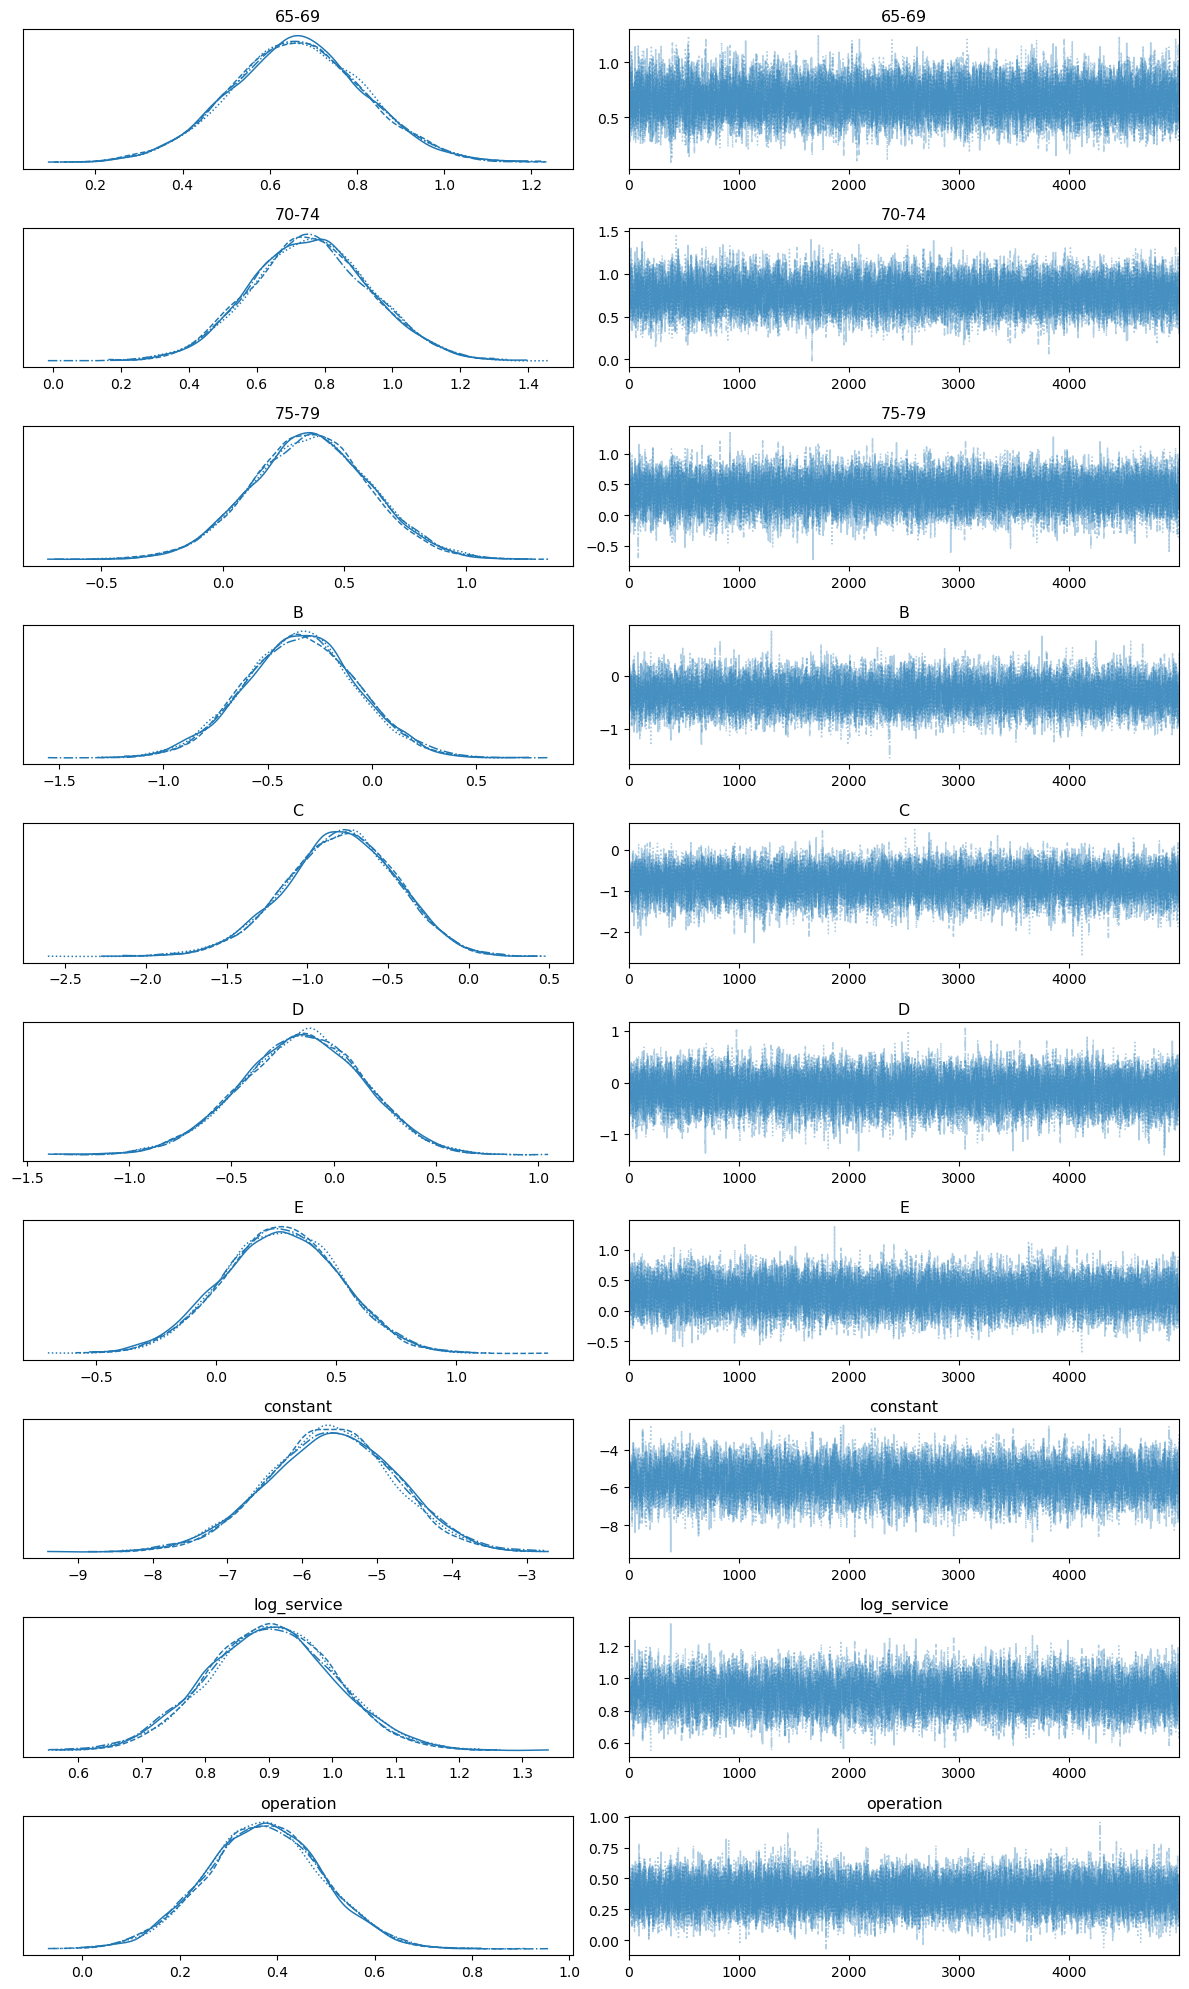

In [11]:
az.plot_trace(sim_param)
plt.tight_layout()
plt.show()

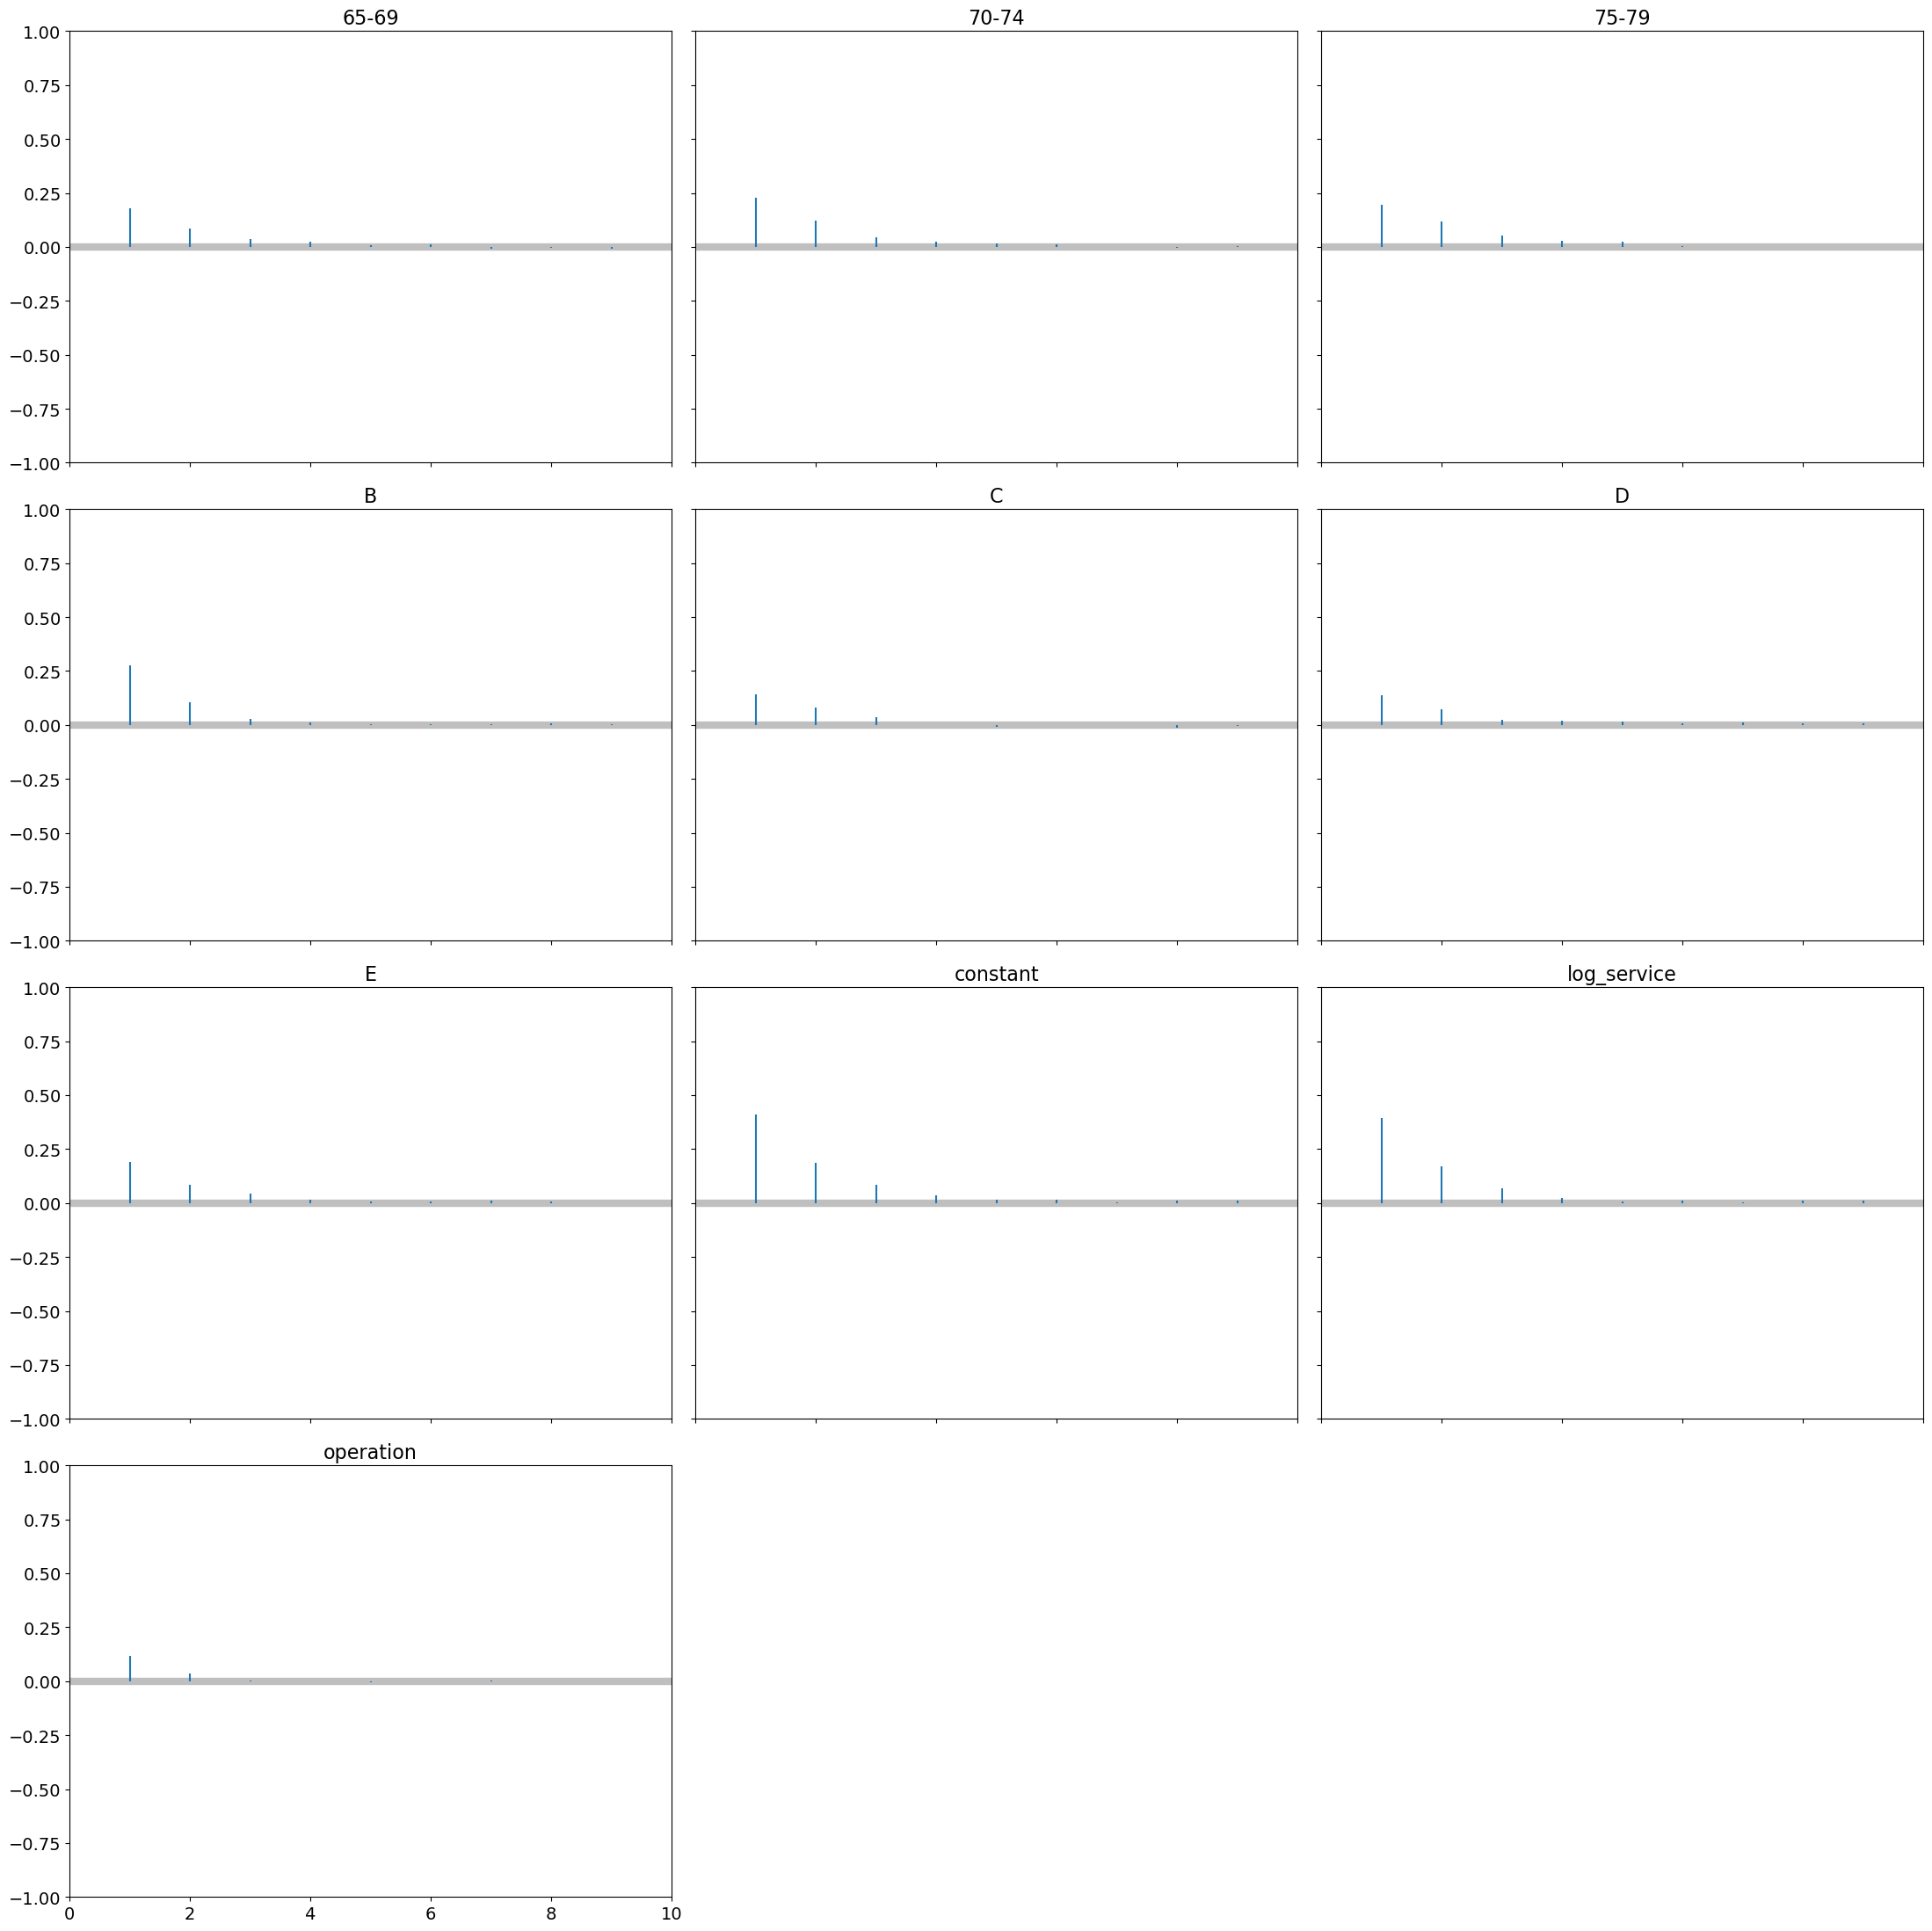

In [12]:
az.plot_autocorr(sim_param, max_lag=10, combined=True)
plt.tight_layout()
plt.show()

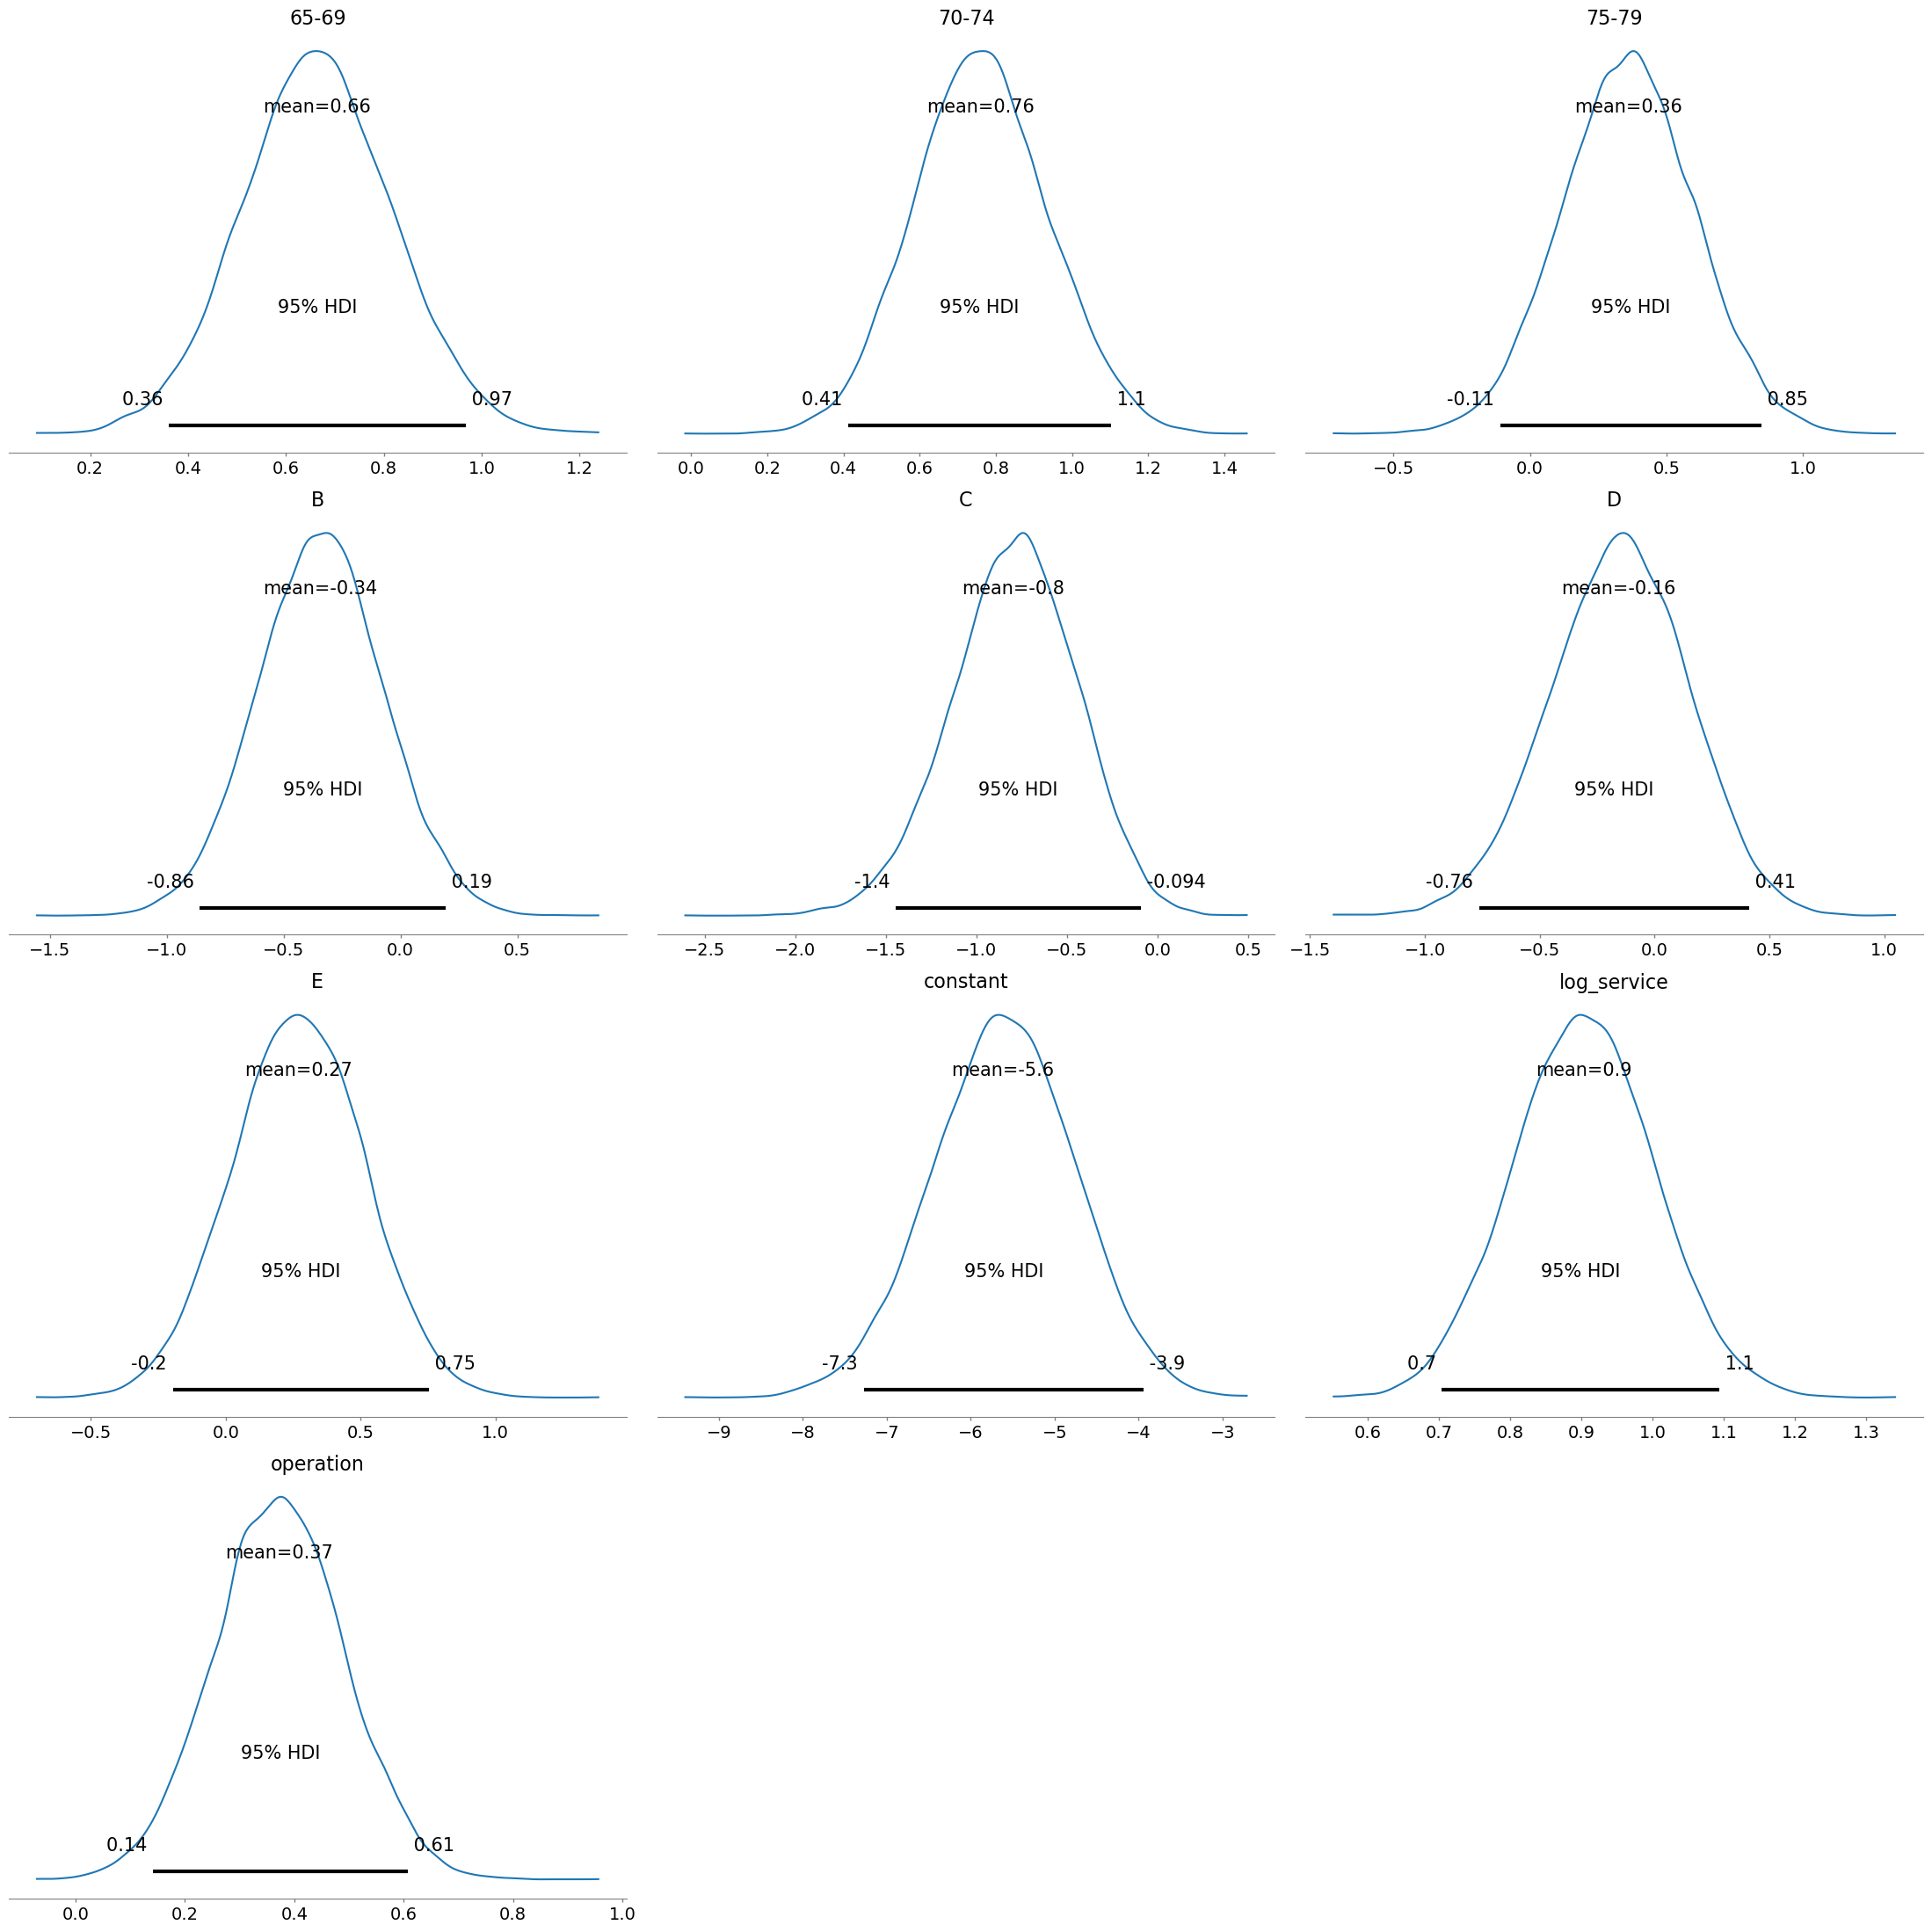

In [13]:
az.plot_posterior(sim_param, kind='kde', point_estimate='mean', hdi_prob=0.95)
plt.tight_layout()
plt.show()